# Setup

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import datasets
import torchvision.transforms as transforms
#from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils.data import sampler

to_float = torch.float
to_long = torch.long

if torch.cuda.is_available():
  device = torch.device('cuda')
else:
  device = torch.device('cpu')
print(device)

cpu


# 加载数据集

In [2]:
batch_size = 64

# 将数据转换为torch.FloatTensor，并标准化。
transform = transforms.Compose([
    transforms.ToTensor(),
    #transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
    transforms.Normalize(mean=[0.5], std=[0.5])
    ])

# 选择训练集与测试集的数据
train_data = datasets.CIFAR10('data', train=True,
                              download=True, transform=transform)
test_data = datasets.CIFAR10('data', train=False,
                             download=True, transform=transform)

# prepare data loaders (combine dataset and sampler)
NUM_TRAIN = 49000
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size,
    sampler=sampler.SubsetRandomSampler(range(NUM_TRAIN)))
valid_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, 
    sampler=sampler.SubsetRandomSampler(range(NUM_TRAIN, 50000)))
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size)

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting data/cifar-10-python.tar.gz to data
Files already downloaded and verified


# 搭建网络

In [3]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.net = nn.Sequential(
            #3*32*32
            nn.Conv2d(3, 16, 3, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            
            #16*16*16
            nn.Conv2d(16, 32, 3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            
            #32*8*8
            nn.Conv2d(32, 64, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            
            #64*4*4
            nn.Flatten(),
            nn.Linear(64*4*4, 500),
            nn.ReLU(),
            
            nn.Linear(500, 6),
        )
        
    def forward(self, x):
        return self.net(x)
model = Net()
print(model)
optimizer = optim.SGD(model.parameters(), lr=0.01)

Net(
  (net): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU()
    (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (11): Flatten(start_dim=1, end_dim=-1)
    (12): Linear(in_features=1024, out_features=500, bias=True)
    (13): ReLU()
    (14): Linear(in_features=500, out_features=6, bias=True)
  )
)


# 准确率检验函数

In [4]:
def check_accuracy_part34(loader, model):
  #if loader.dataset.train:
  #  print('Checking accuracy on validation set')
  #else:
  #  print('Checking accuracy on test set')   
  num_correct = 0
  num_samples = 0
  model.eval()  # set model to evaluation mode
  with torch.no_grad():
    for x, y in loader:
      x = x.to(device=device, dtype=to_float)  # move to device, e.g. GPU
      y = y.to(device=device, dtype=to_long).clamp(max=5)
      scores = model(x)
      _, preds = scores.max(1)
      num_correct += (preds == y).sum()
      num_samples += preds.size(0)
    acc = float(num_correct) / num_samples
    print('Got %d / %d correct (%.2f)' % (num_correct, num_samples, 100 * acc))
  return acc

# 训练网络

In [ ]:
epochs = 5
num_prints = epochs * len(train_loader) // 100 + 1
acc_history = torch.zeros(num_prints, dtype=to_float)
iter_history = torch.zeros(num_prints, dtype=to_long)
model = model.to(device=device)# move the model parameters to CPU/GPU
for epoch in range(epochs):
    for t, (x, y) in enumerate(train_loader):
        model.train()
        # Move the data to the proper device (GPU or CPU)
        x = x.to(device=device, dtype=to_float)
        y = y.to(device=device, dtype=to_long).clamp(max=5)
        
        # Forward pass: compute scores and loss
        scores = model(x)
        loss = F.cross_entropy(scores, y)
        
        optimizer.zero_grad()
        
        #Backwards pass: compute the gradient
        loss.backward()
        
        #Update the parameters
        optimizer.step()
        
        tt = t + epoch * len(train_loader)
        
        if tt % 100 == 0 or (epoch == epochs - 1 and t == len(train_loader) - 1):
            print("Epoch: %d, Iteration: %d, loss = %.4f" %(epoch, tt, loss.item()))
            acc = check_accuracy_part34(valid_loader, model)
            acc_history[tt // 100] = acc
            iter_history[tt // 100] = tt
            print()

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


Epoch: 0, Iteration: 0, loss = 1.8198
Got 525 / 1000 correct (52.50)

Epoch: 0, Iteration: 100, loss = 1.3629
Got 525 / 1000 correct (52.50)

Epoch: 0, Iteration: 200, loss = 1.5051
Got 533 / 1000 correct (53.30)

Epoch: 0, Iteration: 300, loss = 1.3095
Got 550 / 1000 correct (55.00)

Epoch: 0, Iteration: 400, loss = 0.9959
Got 542 / 1000 correct (54.20)

Epoch: 0, Iteration: 500, loss = 1.1138
Got 569 / 1000 correct (56.90)

Epoch: 0, Iteration: 600, loss = 1.1972
Got 566 / 1000 correct (56.60)

Epoch: 0, Iteration: 700, loss = 1.0561
Got 556 / 1000 correct (55.60)

Epoch: 1, Iteration: 800, loss = 1.0673
Got 578 / 1000 correct (57.80)

Epoch: 1, Iteration: 900, loss = 1.1245
Got 575 / 1000 correct (57.50)

Epoch: 1, Iteration: 1000, loss = 1.0993
Got 598 / 1000 correct (59.80)

Epoch: 1, Iteration: 1100, loss = 1.1504
Got 595 / 1000 correct (59.50)

Epoch: 1, Iteration: 1200, loss = 0.9967
Got 588 / 1000 correct (58.80)

Epoch: 1, Iteration: 1300, loss = 1.0081
Got 615 / 1000 correct

# 验证集准确率曲线图

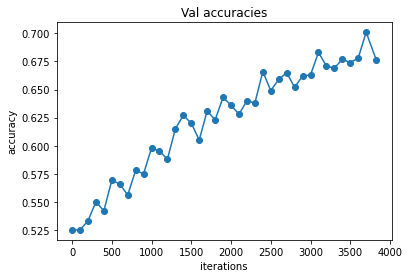

In [ ]:
import matplotlib.pyplot as plt
plt.title('Val accuracies')
plt.plot(iter_history, acc_history, '-o')
plt.xlabel('iterations')
plt.ylabel('accuracy')
plt.show()

# 测试集预测

Predict label is:  tensor([5])
Real lable is:  tensor([0])


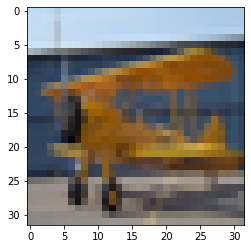

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

data_loader = torch.utils.data.DataLoader(test_data, batch_size=1, shuffle=True)
image, label = next(iter(data_loader))
image = image.to(device=device, dtype=to_float)
label = label.to(device=device, dtype=to_long).clamp(max=5)
scores = model(image)
_, pred = scores.max(1)
print('Predict label is: ', pred)
#to_pil_image = transforms.ToPILImage()
#img = to_pil_image(image[0])
img = image[0].cpu().numpy().transpose(1,2,0)
mean = [0.5]
std = [0.5]
img = img * std + mean
#plt.figure(figsize=(1, 1))
plt.imshow(img)
print('Real lable is: ', label)

#x_test = x_test.to(device=device, dtype=to_float)
#y_test = 

# 改进
## 网络模型

In [7]:
class Net_pro(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.net = nn.Sequential(
            #3*32*32
            nn.Conv2d(3, 16, 3, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            
            #16*16*16
            nn.Conv2d(16, 32, 3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            
            #32*8*8
            nn.Conv2d(32, 64, 3, padding=1),
            #nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            
            #64*4*4
            nn.Flatten(),
            nn.Linear(64*4*4, 500),
            nn.ReLU(),
            
            nn.Linear(500, 6),
        )
        
    def forward(self, x):
        return self.net(x)
model_pro = Net_pro()
print(model_pro)
optimizer = optim.SGD(model_pro.parameters(), lr=0.01)

Net_pro(
  (net): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU()
    (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (11): Flatten(start_dim=1, end_dim=-1)
    (12): Linear(in_features=1024, out_features=500, bias=True)
    (13): ReLU()
    (14): Linear(in_features=500, out_features=6, bias=True)
  )
)


## 增加Epoch数

In [8]:
epochs = 8
num_prints = epochs * len(train_loader) // 100 + 1
acc_history = torch.zeros(num_prints, dtype=to_float)
iter_history = torch.zeros(num_prints, dtype=to_long)
model_pro = model_pro.to(device=device)# move the model parameters to CPU/GPU
for epoch in range(epochs):
    for t, (x, y) in enumerate(train_loader):
        model_pro.train()
        # Move the data to the proper device (GPU or CPU)
        x = x.to(device=device, dtype=to_float)
        y = y.to(device=device, dtype=to_long).clamp(max=5)
        
        # Forward pass: compute scores and loss
        scores = model_pro(x)
        loss = F.cross_entropy(scores, y)
        
        optimizer.zero_grad()
        
        #Backwards pass: compute the gradient
        loss.backward()
        
        #Update the parameters
        optimizer.step()
        
        tt = t + epoch * len(train_loader)
        
        if tt % 100 == 0 or (epoch == epochs - 1 and t == len(train_loader) - 1):
            print("Epoch: %d, Iteration: %d, loss = %.4f" %(epoch, tt, loss.item()))
            acc = check_accuracy_part34(valid_loader, model_pro)
            acc_history[tt // 100] = acc
            iter_history[tt // 100] = tt
            print()

Epoch: 0, Iteration: 0, loss = 1.8526
Got 209 / 1000 correct (20.90)

Epoch: 0, Iteration: 100, loss = 1.3261
Got 526 / 1000 correct (52.60)

Epoch: 0, Iteration: 200, loss = 1.3179
Got 528 / 1000 correct (52.80)

Epoch: 0, Iteration: 300, loss = 1.2818
Got 538 / 1000 correct (53.80)

Epoch: 0, Iteration: 400, loss = 1.2572
Got 548 / 1000 correct (54.80)

Epoch: 0, Iteration: 500, loss = 1.1343
Got 565 / 1000 correct (56.50)

Epoch: 0, Iteration: 600, loss = 0.9959
Got 580 / 1000 correct (58.00)

Epoch: 0, Iteration: 700, loss = 1.0004
Got 579 / 1000 correct (57.90)

Epoch: 1, Iteration: 800, loss = 0.9619
Got 596 / 1000 correct (59.60)

Epoch: 1, Iteration: 900, loss = 0.8732
Got 594 / 1000 correct (59.40)

Epoch: 1, Iteration: 1000, loss = 1.0519
Got 597 / 1000 correct (59.70)

Epoch: 1, Iteration: 1100, loss = 1.0234
Got 623 / 1000 correct (62.30)

Epoch: 1, Iteration: 1200, loss = 0.8663
Got 624 / 1000 correct (62.40)

Epoch: 1, Iteration: 1300, loss = 1.0694
Got 629 / 1000 correct

## 验证集识别准确率

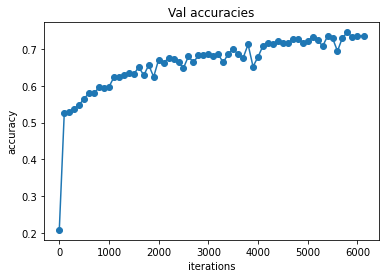

In [10]:
import matplotlib.pyplot as plt
plt.title('Val accuracies')
plt.plot(iter_history, acc_history, '-o')
plt.xlabel('iterations')
plt.ylabel('accuracy')
plt.show()